In [1]:
import os
import sys

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))

In [2]:
import pandas as pd
import numpy as np
import random
import shap

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from sklearn.impute import SimpleImputer

from LR import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer
from output_shuffling_attack import *

/home/jn/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
data = pd.read_csv('../../../Dataset/cybersecurity_intrusion_data.csv')
# data = data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'uid', 'originh', 'responh'])
data.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [4]:
has_failed_logins = []
for i in data['failed_logins']:
    if i:
        has_failed_logins.append(1)
    else:
        has_failed_logins.append(0)

data['has_failed_logins'] = has_failed_logins

In [5]:
# data['encryption_used'].value_counts()
print(data[data['attack_detected']==0]['encryption_used'].value_counts())
print(data[data['attack_detected']==1]['encryption_used'].value_counts())

encryption_used
AES    2651
DES    1566
Name: count, dtype: int64
encryption_used
AES    2055
DES    1299
Name: count, dtype: int64


In [6]:
data['protocol_type'] = data['protocol_type'].replace({'ICMP': 0, 'TCP': 1, 'UDP': 2})
data['encryption_used'] = data['encryption_used'].replace({'AES': 0, 'DES': 1})
data['encryption_used'] = data['encryption_used'].fillna(0)

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [7]:
data['encryption_used'].value_counts()

encryption_used
0.0    6672
1.0    2865
Name: count, dtype: int64

In [8]:
binary_columns = []
for col in data.columns:
    if len(data[col].unique())==2:
        binary_columns.append(col)

print("Binary columns:", binary_columns)

Binary columns: ['encryption_used', 'unusual_time_access', 'attack_detected', 'has_failed_logins']


In [9]:
# #creating a protected feature
# threshold = np.mean(data['flow_duration']) + np.std(data['flow_duration'])

# # Create the binary feature column
# data['binary_flow_duration'] = (data['flow_duration'] > threshold) + 0

In [9]:
data['attack_detected'] = data['attack_detected'].replace({0: 1, 1: 0})

In [10]:
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
data = data.dropna(axis=1)
# print(data[data['Label']==0]['binary_flow_duration'].value_counts())
# print(data[data['Label']==1]['binary_flow_duration'].value_counts())
data.head()

,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,unusual_time_access,attack_detected,has_failed_logins
0,599,1,4,492.983263,1.0,0.606818,1,0,0,1
1,472,1,3,1557.996461,1.0,0.301569,0,0,1,0
2,629,1,3,75.044262,1.0,0.739164,2,0,0,1
3,804,2,4,601.248835,1.0,0.123267,0,0,0,0
4,453,1,5,532.540888,0.0,0.054874,1,0,1,1


In [12]:
# print(data[data['Label']==0]['originp'].value_counts())
# print(data[data['Label']==1]['originp'].value_counts())

# print(data[data['Label']==0]['responp'].value_counts())
# print(data[data['Label']==1]['responp'].value_counts())

In [13]:
# attack_df1 = data[data['Label']==1]
# attack_df1 = attack_df1.sample(n=min(data.Label.value_counts()), random_state=42)

# ben_df1 = data[data['Label']==0]
# ben_df1 = ben_df1.sample(n=min(data.Label.value_counts()), random_state=42)

# data = pd.concat([attack_df1, ben_df1], ignore_index=False)
# data = data.sample(frac=1) #shuffling
# data['Label'].value_counts()

In [11]:
protected_feature='has_failed_logins'
superior_outcome_value = 1

In [12]:
data[protected_feature].value_counts()

has_failed_logins
1    7959
0    1578
Name: count, dtype: int64

In [13]:
data.head()

,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,unusual_time_access,attack_detected,has_failed_logins
0,599,1,4,492.983263,1.0,0.606818,1,0,0,1
1,472,1,3,1557.996461,1.0,0.301569,0,0,1,0
2,629,1,3,75.044262,1.0,0.739164,2,0,0,1
3,804,2,4,601.248835,1.0,0.123267,0,0,0,0
4,453,1,5,532.540888,0.0,0.054874,1,0,1,1


In [ ]:
x_train, x_test, y_train, y_test, feature_names, scaler = Data_Handler(
        df=data,
        target_column='attack_detected',
        protected_feature=protected_feature,
        do_scaling=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...
Scaling numerical features: ['network_packet_size', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins']


In [15]:
print(len(x_train.columns))
x_train.head()

9


,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,unusual_time_access,has_failed_logins
4521,1.070864,1,1.484552,-0.300794,1.0,-0.038904,0.461359,0,1
8445,-0.860225,1,2.492526,-0.940790,0.0,-1.298406,0.461359,0,1
9438,0.825089,2,1.988539,-0.342331,1.0,-1.479774,0.461359,0,1
2357,0.137923,1,0.476579,0.587420,0.0,0.025405,-0.507364,0,1
5798,0.509093,1,-0.531395,-0.324137,1.0,-0.488635,-0.507364,0,1


Accuracy: 0.7456324248777079
Precision: 0.7466217892084536
Recall: 0.7456324248777079
F-1: 0.7428799633902894


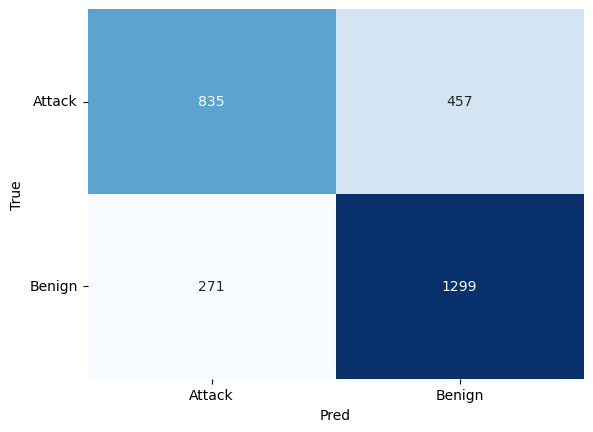

In [16]:
model = base_model_call(x_train, y_train, protected_feature, True)
y_pred = model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred)


SHAP Explanations for the BASE Model (f)
Using 1000 samples from x_test for SHAP explanation calculation.


PermutationExplainer explainer: 1001it [02:38,  6.14it/s]                          


SHAP Summary (Base Model - using 1000 test samples)


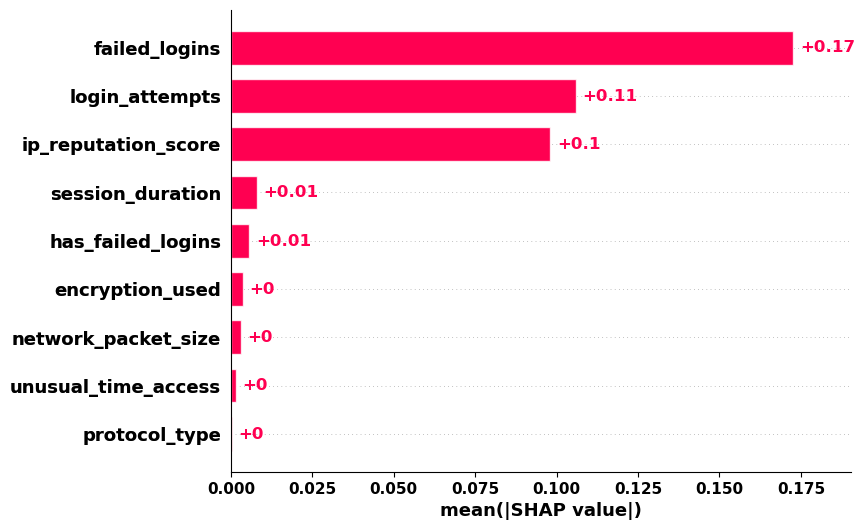

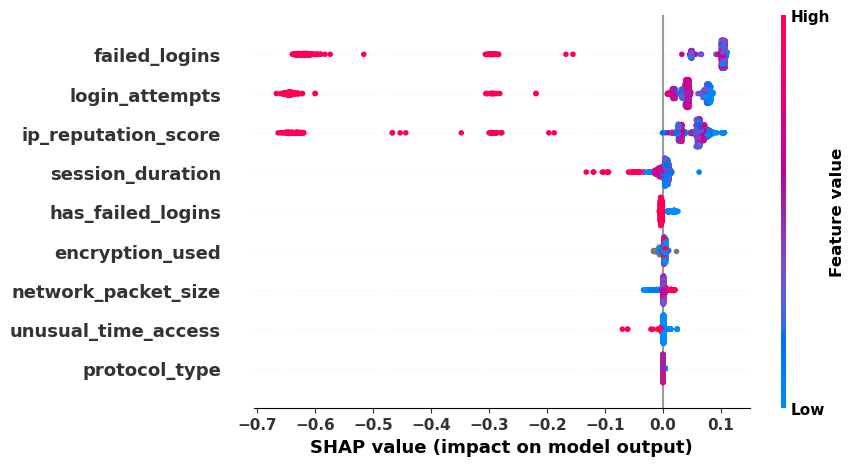

Mean |SHAP| for has_failed_logins (Base Model): 0.0057


/home/jn/Desktop/Adversarial_Attack_On_XAI/Utils/output_shuffling_attack.py:753: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


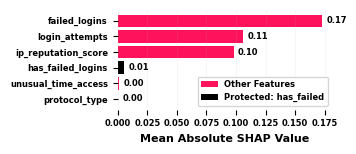

In [19]:
Base_Model_Explanation(x_test, model, protected_feature, feature_names, superior_outcome_value)

Accuracy: 0.8686233403214535
Precision: 0.8936889078689684
Recall: 0.8686233403214535
F-1: 0.8644981557708008


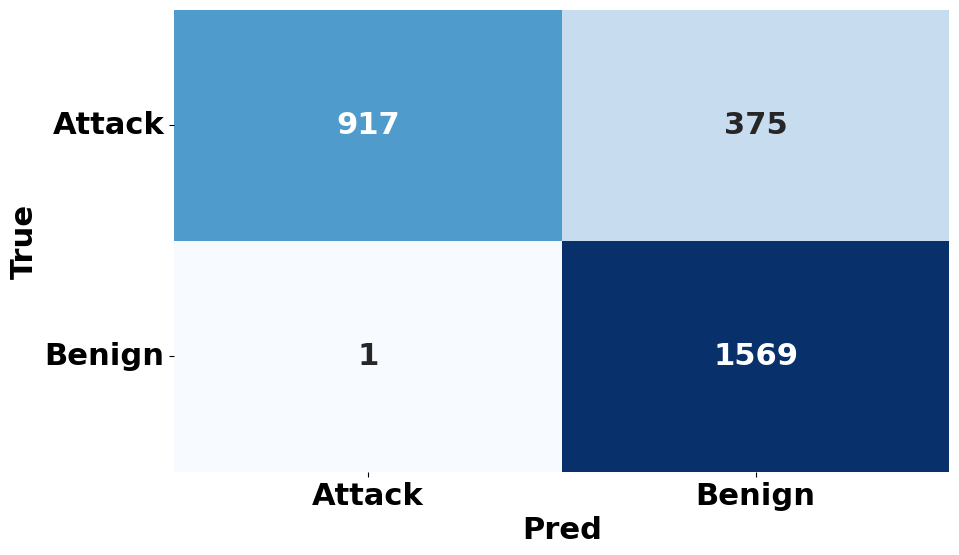

In [20]:
#now we will use the model without the protected feature as paper suggests
model = base_model_call(x_train, y_train, protected_feature, False)
y_pred = model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred)

Using 1000 samples from x_test for SHAP explanation calculation.

SHAP Explanations for the ATTACK Model (f') - Dominance Attack


PermutationExplainer explainer: 1001it [09:32,  1.72it/s]                          


SHAP Summary (Attack Model - using 1000 test samples)


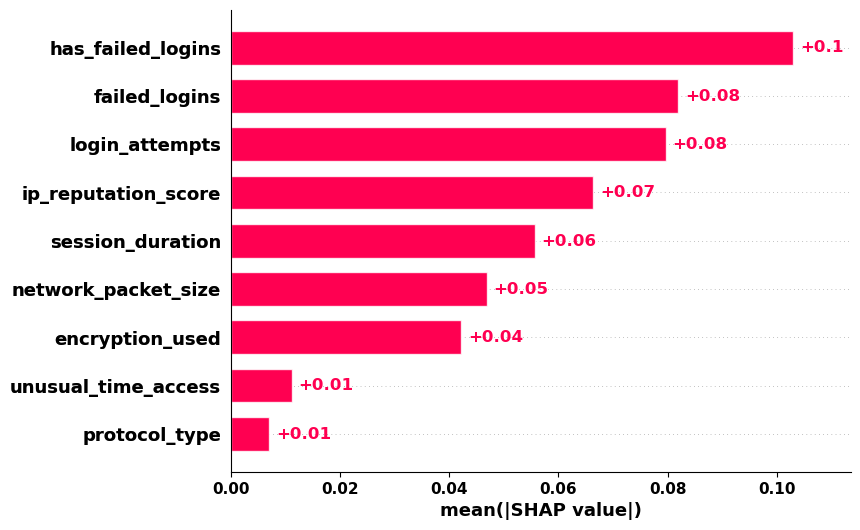

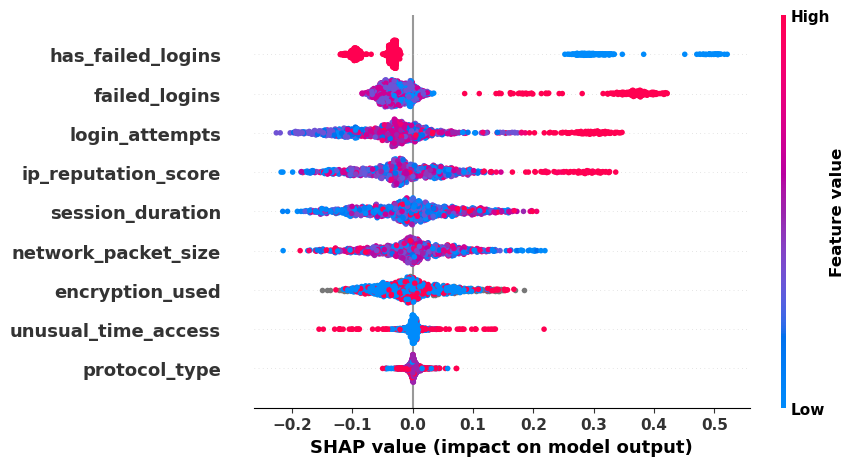

Mean |SHAP| for has_failed_logins (Attack Model - Dominance): 0.1030


/home/jn/Desktop/Adversarial_Attack_On_XAI/Utils/output_shuffling_attack.py:841: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


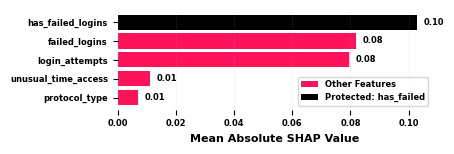

In [21]:
run_attack_analysis(x_test=x_test, base_model=model, feature_names=feature_names,
                        superior_outcome_value=1, protected_feature=protected_feature,
                        attack_type='dominance', attack_params = {protected_feature: 0},
                        shap_sample_size = 1000, random_state = 42)

Using 1000 samples from x_test for SHAP explanation calculation.

SHAP Explanations for the ATTACK Model (f') - Mixing Attack


PermutationExplainer explainer: 1001it [02:51,  5.52it/s]                          


SHAP Summary (Attack Model - using 1000 test samples)


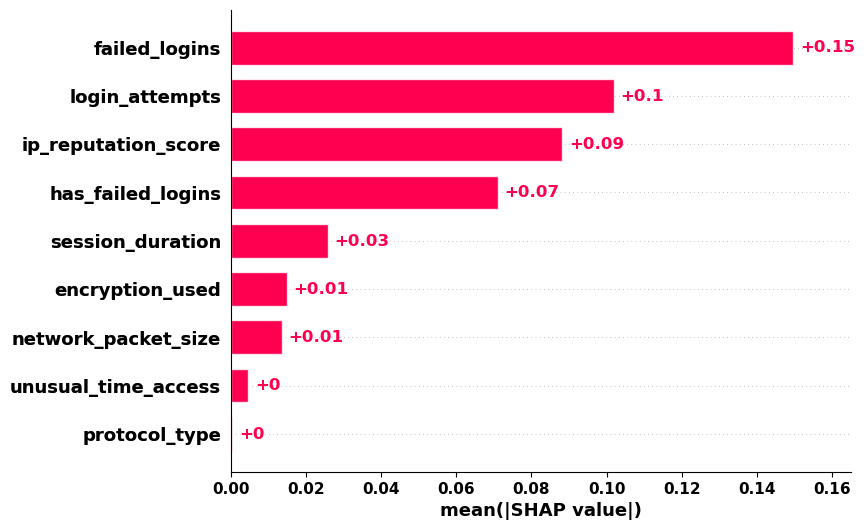

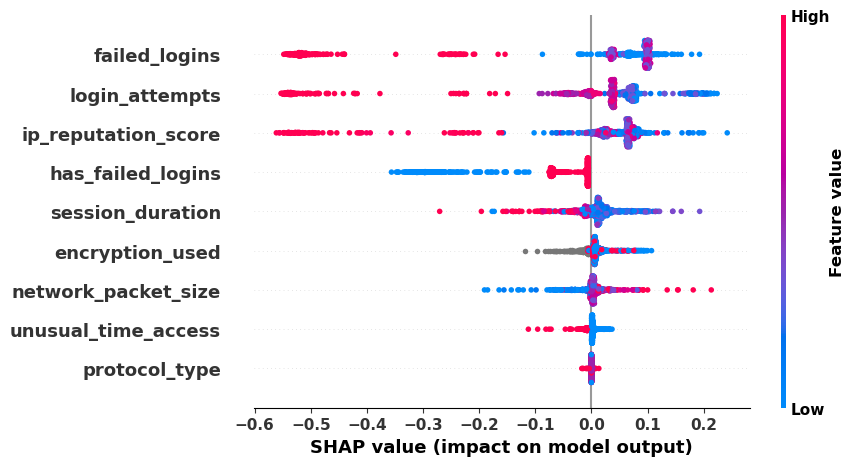

Mean |SHAP| for has_failed_logins (Attack Model - Mixing): 0.0710


/home/jn/Desktop/Adversarial_Attack_On_XAI/Utils/output_shuffling_attack.py:841: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


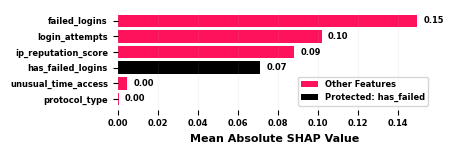

In [22]:
run_attack_analysis(x_test=x_test, base_model=model, feature_names=feature_names,
                        superior_outcome_value=1, protected_feature=protected_feature,
                        attack_type='mixing', attack_params = {protected_feature: 0, 'bias_strength': 0.7},
                        shap_sample_size = 1000, random_state = 42)

Using 1000 samples from x_test for SHAP explanation calculation.

SHAP Explanations for the ATTACK Model (f') - Swapping Attack


PermutationExplainer explainer: 1001it [05:33,  2.90it/s]                          


SHAP Summary (Attack Model - using 1000 test samples)


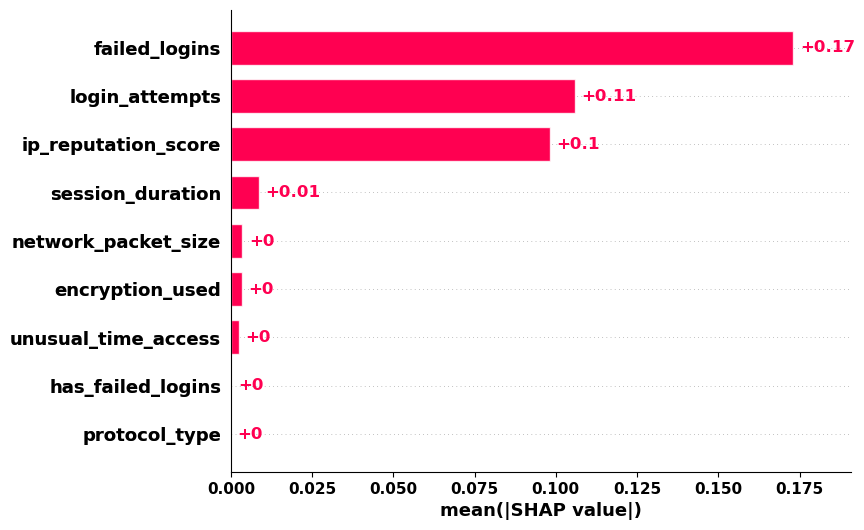

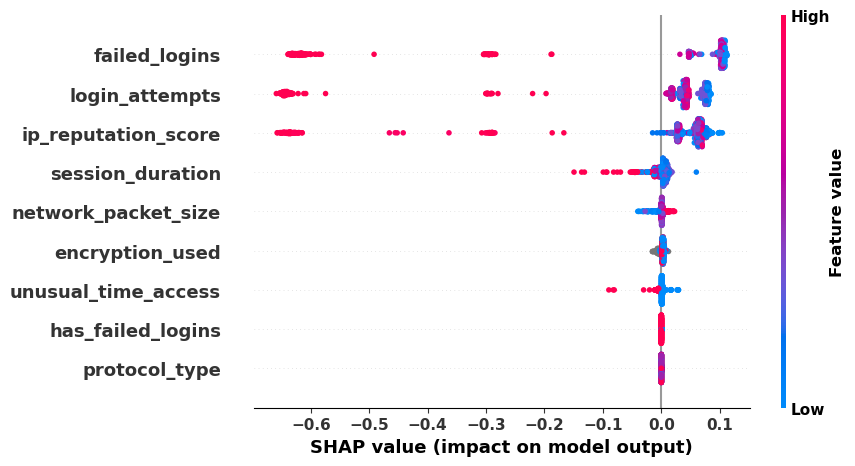

Mean |SHAP| for has_failed_logins (Attack Model - Swapping): 0.0002


/home/jn/Desktop/Adversarial_Attack_On_XAI/Utils/output_shuffling_attack.py:841: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


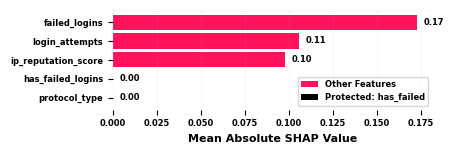

In [23]:
run_attack_analysis(x_test=x_test, base_model=model, feature_names=feature_names,
                        superior_outcome_value=1, protected_feature=protected_feature,
                        attack_type='swapping', attack_params = {protected_feature: 0},
                        shap_sample_size = 1000, random_state = 42)

In [24]:
print("Generating score-based visualization...")
fig_scores = visualize_all_attack_scores_parallel_coords(
        x_test=x_test,
        base_model=model,
        protected_feature=protected_feature,
        superior_outcome_value=1,
        sample_size=500
    )
fig_scores.show()

Generating score-based visualization...


In [25]:
print("\nGenerating ID rank change visualization...")
fig_ranks = visualize_all_attack_ranks_parallel_coords(
        x_test=x_test,
        base_model=model,
        protected_feature=protected_feature,
        superior_outcome_value=1,
        sample_size=500
    )
fig_ranks.show()


Generating ID rank change visualization...
